# SageMaker/DeepAR demo on stock price dataset

This notebook complements the [DeepAR introduction notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/deepar_synthetic/deepar_synthetic.ipynb). 

Here, we will consider a real use case and show how to use DeepAR on SageMaker for predicting the price of the AMZN stock unit.

In particular, we will see how to:
* Prepare the dataset
* Use the SageMaker Python SDK to train a DeepAR model and deploy it
* Make requests to the deployed model to obtain forecasts interactively
* Illustrate advanced features of DeepAR: missing values, additional time features, non-regular frequencies and category information

Running this notebook takes around 40 min on a ml.c4.2xlarge for the training, and inference is done on a ml.m4.xlarge (the usage time will depend on how long you leave your served model running).

For more information see the DeepAR [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html) or [paper](https://arxiv.org/abs/1704.04110), 

In [1]:
%matplotlib inline

import sys
from urllib.request import urlretrieve
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

In [2]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [3]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()  

Before starting, we can override the default values for the following:
- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.

In [4]:
s3_data_path = "s3://"
s3_output_path = "s3://"

Next, we configure the container image to be used for the region that we are running in.

In [5]:
region = sagemaker_session.boto_region_name
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

### Import stock price dataset and upload it to S3 to make it available for Sagemaker

In [6]:
data = pd.read_csv("data/AMZN.csv", sep=",",  index_col=0, parse_dates=True, decimal=',')
data = data.astype("float64")
num_timeseries = data.shape[1]
timeseries = []
data_day = data.asfreq('1D', method='backfill')

for i in range(0, num_timeseries):
    timeseries.append(np.trim_zeros(data_day.iloc[:,i], trim='f'))

Let's have a look on the data:

In [7]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
1999-05-24,64.31250,64.68750,58.0000,58.75000,58.75000,14253800.0
1999-05-25,58.62500,60.56250,55.6875,55.78125,55.78125,15510200.0
1999-05-26,56.59375,60.93750,52.2500,60.46875,60.46875,21158600.0
1999-05-27,59.81250,60.28125,57.0000,57.28125,57.28125,13573400.0
1999-05-28,57.81250,60.18750,56.0000,59.37500,59.37500,9680200.0


### Plot Volume and stock unit price

Text(0,0.5,'Volume')

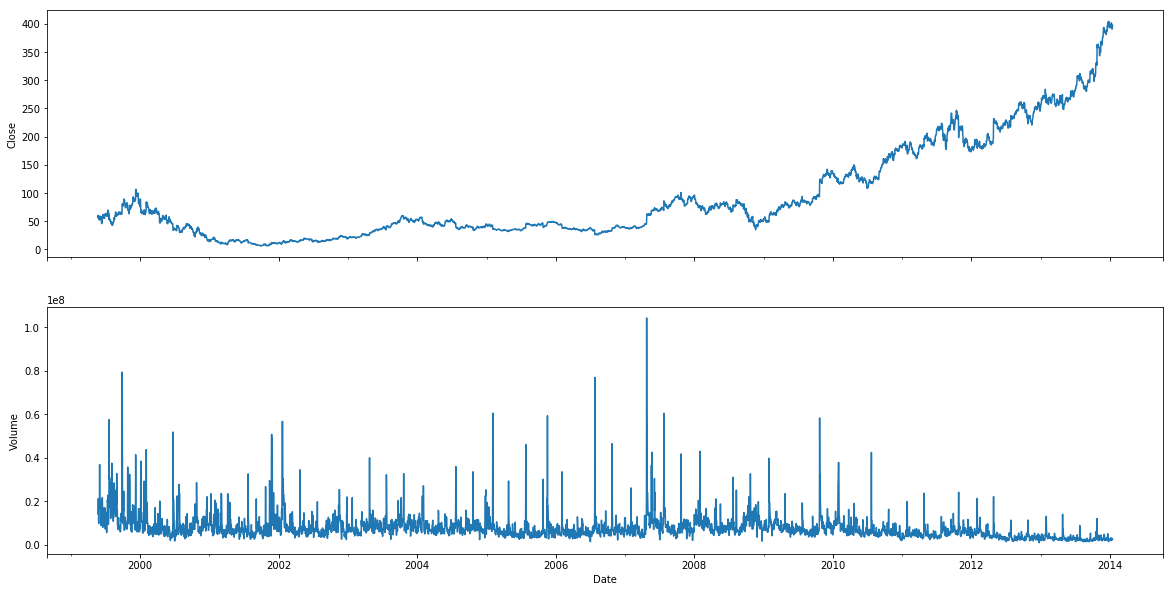

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
axx = axs.ravel()

timeseries[3].loc["1999-01-01":"2014-01-14"].plot(ax=axx[0])
axx[0].set_xlabel("Date")
axx[0].set_ylabel("Close") 

timeseries[5].loc["1999-01-01":"2014-01-14"].plot(ax=axx[1]) 
axx[1].set_xlabel("Date")
axx[1].set_ylabel("Volume")

### Train and Test splits

Often times one is interested in evaluating the model or tuning its hyperparameters by looking at error metrics on a hold-out test set. Here we split the available data into train and test sets for evaluating the trained model. For standard machine learning tasks such as classification and regression, one typically obtains this split by randomly separating examples into train and test sets. However, in forecasting it is important to do this train/test split based on time rather than by time series.

In this example, we will reserve the last section of each of the time series for evalutation purpose and use only the first part as training data. 

In [9]:
# we predict for 20 days
prediction_length = 20

# we also use 20 days as context length, this is the number of state updates accomplished before making predictions
context_length = 20

In [10]:
freq = "1D"
start_dataset = pd.Timestamp("1999-05-24 00:00:00", freq=freq)
end_training = pd.Timestamp("2018-05-24 00:00:00", freq=freq)

The DeepAR JSON input format represents each time series as a JSON object. In the simplest case each time series just consists of a start time stamp (``start``) and a list of values (``target``). For more complex cases, DeepAR also supports the fields ``dynamic_feat`` for time-series features and ``cat`` for categorical features, which we will use  later.

In [11]:

training_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training - 1].tolist()  # We use -1, because pandas indexing includes the upper bound 
    }
    for ts in timeseries
]
print(len(training_data))

6


As test data, we will consider time series extending beyond the training range: these will be used for computing test scores, by using the trained model to forecast their trailing 7 days, and comparing predictions with actual values.
To evaluate our model performance on more than one week, we generate test data that extends to 1, 2, 3, 4 weeks beyond the training range. This way we perform *rolling evaluation* of our model.

In [12]:
num_test_windows = 4

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training + k * prediction_length].tolist()
    }
    for k in range(1, num_test_windows + 1) 
    for ts in timeseries
]
print(len(test_data))

24


In [13]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [14]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 75.1 ms, sys: 15.3 ms, total: 90.5 ms
Wall time: 89 ms


In [15]:
s3 = boto3.resource('s3')
def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print('File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)

In [16]:
%%time
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

File s3://sagemaker-rauscn-us-west-2/s3://sagemaker-rauscn-us-west-2/timeseries/train/train.json already exists.
Set override to upload anyway.

File s3://sagemaker-rauscn-us-west-2/s3://sagemaker-rauscn-us-west-2/timeseries/test/test.json already exists.
Set override to upload anyway.

CPU times: user 23.4 ms, sys: 3.23 ms, total: 26.6 ms
Wall time: 147 ms


Let's have a look to what we just wrote to S3.

In [17]:
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(s3_data_path + "/train/train.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "1999-05-24 00:00:00", "target": [64.3125, 58.625, 56.59375, 59.8125, 57.8125, 55.75, 55.7...


We are all set with our dataset processing, we can now call DeepAR to train a model and generate predictions.

### Train a model

Here we define the estimator that will launch the training job.

In [18]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p2.xlarge',
    output_path=s3_output_path
)

Next we need to set the hyperparameters for the training job. For example frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options (number of epochs, batch size, learning rate...). We use default parameters for every optional parameter in this case (you can always use [Sagemaker Automated Model Tuning](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune them).

In [19]:
hyperparameters = {
    "time_freq": "1D",
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

In [20]:
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test. This is done by predicting the last `prediction_length` points of each time-series in the test set and comparing this to the actual value of the time-series. 

**Note:** the next cell may take a few minutes to complete, depending on data size, model complexity, training options.

In [ ]:
%%time
data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels, wait=True)

Since you pass a test set in this example, accuracy metrics for the forecast are computed and logged (see bottom of the log).
You can find the definition of these metrics from [our documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html). You can use these to optimize the parameters and tune your model or use SageMaker's [Automated Model Tuning service](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune the model for you.

### Create endpoint and predictor
Now that we have a trained model, we can use it to perform predictions by deploying it to an endpoint.

**Note: Remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.**

        
To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [22]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

In [ ]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor)


In [345]:
predictor.predict(ts=timeseries[3][0:1000], quantiles=[0.10, 0.5, 0.90]).head()

,0.1,0.5,0.9
2002-02-17,12.533812,13.329017,14.267890
2002-02-18,12.329336,13.219817,14.485090
2002-02-19,12.273710,13.409566,14.402533
2002-02-20,12.570989,13.651830,14.434640
2002-02-21,12.719358,13.484809,14.380569


In [24]:
print(timeseries[3][1000:1010])

2002-02-17    13.01
2002-02-18    13.01
2002-02-19    13.01
2002-02-20    12.96
2002-02-21    13.26
2002-02-22    13.07
2002-02-23    13.73
2002-02-24    13.73
2002-02-25    13.73
2002-02-26    14.40
Freq: D, Name: Close, dtype: float64


Below we define a plotting function that queries the model and displays the forecast.

In [25]:
def plot(
    predictor, 
    target_ts, 
    cat=None, 
    dynamic_feat=None, 
    forecast_date=end_training, 
    show_samples=False, 
    plot_history=7 * 12,
    confidence=80
):
    print("calling served model to generate predictions starting from {}".format(str(forecast_date)))
    assert(confidence > 50 and confidence < 100)
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
        
    # we first construct the argument to call our model
    args = {
        "ts": target_ts[:forecast_date],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": 100
    }


    if dynamic_feat is not None:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 3))
        ax = plt.subplot(1,1,1)
    
    if cat is not None:
        args["cat"] = cat
        ax.text(0.9, 0.9, 'cat = {}'.format(cat), transform=ax.transAxes)

    # call the end point to get the prediction
    prediction = predictor.predict(**args)

    # plot the samples
    if show_samples: 
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].plot(color='lightskyblue', alpha=0.2, label='_nolegend_')
                
                
    # plot the target
    target_section = target_ts[forecast_date-plot_history:forecast_date+prediction_length]
    target_section.plot(color="black", label='target')
    
    # plot the confidence interval and the median predicted
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color="b", alpha=0.3, label='{}% confidence interval'.format(confidence)
    )
    prediction["0.5"].plot(color="b", label='P50')
    ax.legend(loc=2)    
    
    # fix the scale as the samples may change it
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)
    
    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                index=pd.DatetimeIndex(start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)),
                data=f
            )
            feat_ts[forecast_date-plot_history:forecast_date+prediction_length].plot(ax=ax, color='g')

We can interact with the function previously defined, to look at the forecast of any customer at any point in (future) time. 

For each request, the predictions are obtained by calling our served model on the fly.

Here we forecast the consumption of an office after week-end (note the lower week-end consumption). 
You can select any time series and any forecast date, just click on `Run Interact` to generate the predictions from our served endpoint and see the plot.

In [26]:
style = {'description_width': 'initial'}

@interact_manual( 
    forecast_day=IntSlider(min=0, max=100, value=51, style=style),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    history_weeks_plot=IntSlider(min=1, max=20, value=1, style=style),
    show_samples=Checkbox(value=False),
    continuous_update=False
)
def plot_interact(forecast_day, confidence, history_weeks_plot, show_samples):
    plot(
        predictor,
        target_ts=timeseries[3],
        forecast_date=end_training + datetime.timedelta(days=forecast_day),
        show_samples=show_samples,
        plot_history=history_weeks_plot * 12 * 7,
        confidence=confidence
    )

interactive(children=(IntSlider(value=51, description='forecast_day', style=SliderStyle(description_width='ini…